In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-jbsrn4ok
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-jbsrn4ok
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=641dbc659f3c84b6249a91040c236ce1c78f63e797abba05946350a03f73ea73
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgnke21o/wheels/db/c1/1f/a2bb07bbb4a1ce3c43921252aeafaa6205f08637e292496f04
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools,

In [2]:
%%cuda --name R3_parallel.cu

#include <iostream>
#include <bits/stdc++.h>
#include <fstream>

using namespace std;
const double INF_ = 1e9;
const double epsilon = 0.0000000001;

typedef vector<double> vd;
typedef vector<vd> vvd;
typedef vector<bool> vb;
typedef vector<vb> vvb;
typedef vector<int> vi;
typedef vector<vi> vvi;
typedef pair<int,int> ii;
typedef vector<ii> vii;

#define pb push_back
#define F first
#define S second
#define MP make_pair

void printgrid(vvi &grid){
    for(int i=0;i<grid.size();i++){
        for(int j=0;j<grid[i].size();j++){
            cout<<grid[i][j]<<" ";
        }
        cout<<endl;
    }
    cout<<endl;
}

void readfile_and_make_grid(vvi &grid){
    //std::ifstream infile("/Users/avirajbevli/Desktop/Sem10/HPPP/cuda_term project/data/cdnf43w/heights.txt");
    cout<<"Reading from input file..."<<endl;
    std::ifstream infile("heights.txt");
    if(!infile.is_open()) {
        std::cerr << "Error: Could not open read file" << std::endl;
        return  ;
    }

    string line;
    while(std::getline(infile, line)) {
        vi temp;
        string str; 
        int i=0;
        while(i<line.size()){
            if(line[i]==','){
                temp.pb(stoi(str));
                str="";
                i++;
            }
            else{
                str+=line[i];
            }
            i++;
        }
        grid.pb(temp);
    }
    infile.close();
    cout<<"Done reading"<<endl;
}

// function for line generation
vii plotPixel(int x1, int y1, int x2, int y2, int dx, int dy, int decide){
    // pk is initial decision making parameter
    // Note:x1&y1,x2&y2, dx&dy values are interchanged
    // and passed in plotPixel function so
    // it can handle both cases when m>1 & m<1
    int pk = 2 * dy - dx;
    vii line;
    for (int i = 0; i <= dx; i++) {
        // cout << x1 << "," << y1 << endl;
        // checking either to decrement or increment the
        // value if we have to plot from (0,100) to (100,0)
        x1 < x2 ? x1++ : x1--;
        if (pk < 0) {
            // decision value will decide to plot
            // either  x1 or y1 in x's position
            if (decide == 0) {
                // putpixel(x1, y1, RED);
                line.pb(MP(x1,y1));
                pk = pk + 2 * dy;
            }
            else {
                //(y1,x1) is passed in xt
                // putpixel(y1, x1, YELLOW);
                line.pb(MP(y1,x1));
                pk = pk + 2 * dy;
            }
        }
        else {
            y1 < y2 ? y1++ : y1--;
            if (decide == 0) {
                line.pb(MP(x1,y1));
                // putpixel(x1, y1, RED);
            }
            else {
                line.pb(MP(y1,x1));
                //  putpixel(y1, x1, YELLOW);
            }
            pk = pk + 2 * dy - 2 * dx;
        }
    }
    return line;
}

vii bresenham(int x1, int y1, int x2, int y2){
    int dx = abs(x2 - x1);
    int dy = abs(y2 - y1);
    // If slope is less than one
    if (dx > dy) {
        // passing argument as 0 to plot(x,y)
        return plotPixel(x1, y1, x2, y2, dx, dy, 0);
    }
 
    // if slope is greater than or equal to 1
    else {
        // passing argument as 1 to plot (y,x)
        return plotPixel(y1, x1, y2, x2, dy, dx, 1);
    }
}

double calc_dist(ii p1, ii p2){
    double x1=p1.F; double y1=p1.S;
    double x2=p2.F; double y2=p2.S;
    double dx = x2-x1; double dy = y2-y1;
    return sqrt((dx*dx) + (dy*dy));
}

bool isvalid(ii p, int n, int m, double dist_from_origin, double range){
    if(p.F < 0 || p.S < 0) return 0;
    if(p.F >= n || p.S >= m) return 0;
    if(dist_from_origin > range) return 0;
    return 1;
}

vii find_points_in_range(ii observer, vvi &grid, double range, vvi& viewshed){
    int n = grid.size();
    int m = grid[0].size();

    // bfs
    int dx[4] = {0,1,0,-1};
    int dy[4] = {1,0,-1,0};
    queue<ii> q;
    q.push(observer);
    
    vii pts_inrange;
    //cout<<"Points in range: "<<endl;
    while(!q.empty()){
        ii curr = q.front();
        pts_inrange.pb(curr);
        viewshed[curr.F][curr.S]=1;
        q.pop();
        //cout<<curr.F<<","<<curr.S<<" ";
        for(int i=0;i<4;i++){
            ii next = MP(curr.F + dx[i], curr.S + dy[i]);
            double dist_from_origin = calc_dist(observer, next);
            if(isvalid(next, n, m, dist_from_origin, range)){
                if(viewshed[next.F][next.S]==-1){
                    q.push(next);
                }
            }
        }
    }
    return pts_inrange;
}

double find_slope(vvi& grid, ii observer, ii curr, int observer_ht){
    double dist = calc_dist(observer, curr);
    double dh = double(grid[curr.F][curr.S]) - (double(grid[observer.F][observer.S]) + (double)observer_ht);
    double m_curr = dh/dist;
    return m_curr;
}

// -1: out of range, 0: not visible, 1: visible
void calculate_viewshed_and_writefile_r3(vvi &grid){
    // parameters to the algo
    ii observer = MP(1000,3000);
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>

    int n = grid.size();
    int m = grid[0].size();

    vvi viewshed(n,vi(m,-1));

    // double range = 500;
    // vii pts_inrange = find_points_in_range(observer,grid,range,viewshed);
    // cout<<"Number of points in range: "<<pts_inrange.size()<<endl;

    // for(int i=0;i<pts_inrange.size();i++){
    //     ii curr = pts_inrange[i];
    //     vii line = bresenham(observer.F, observer.S, curr.F, curr.S);
    //     // do something with the obtained line
    //     double m_max = -INF_;
    //     ii observer = line[0];
    //     for(int i=1;i<line.size();i++){
    //         double dist = calc_dist(observer, curr);
    //         double dh = grid[curr.F][curr.S] - grid[observer.F][observer.S];
    //         double m_curr = dist/dh;
    //         if(m_curr >= m_max){
    //             m_max = m_curr;
    //         }
    //         else{
    //             viewshed[curr.F][curr.S]=0;
    //         }
    //     }
    // }
    int range = 400;
    int li = max(0, (observer.F) - range);
    int ri = min(n,(observer.F) + range);
    int lj = max(0, (observer.S) - range);
    int rj = min(m,(observer.S) + range);
    cout<<"li:"<<li<<",ri:"<<ri<<", lj:"<<lj<<",rj:"<<rj<<endl;
    for(int i = li; i < ri; i++){
        for(int j = lj; j < rj; j++){
            ii curr = MP(i,j);
            viewshed[curr.F][curr.S]=1;
        } 
    }
    for(int i = li; i < ri; i++){
        for(int j = lj; j < rj; j++){
            ii target = MP(i,j);
            double m_target = find_slope(grid, observer, target, observer_ht);
            vii line = bresenham(observer.F, observer.S, target.F, target.S);
            // do something with the obtained line

            viewshed[target.F][target.S]=1; // target is visible by default
            double m_max = -INF_;
            int linesz = line.size();
            for(int lid=1;lid<linesz-1;lid++){
                // ii curr = line[lid];
                double m_curr = find_slope(grid, observer, line[lid], observer_ht);
                m_max = max(m_max, m_curr);
                // if(m_curr >= m_max){
                //     m_max = m_curr;
                // }
                // else{
                //     viewshed[curr.F][curr.S]=0;
                // }
            }
            if(m_max > m_target + epsilon){
                viewshed[target.F][target.S]=0;
            }
        } 
    }

    cout<<"Writing to output viewshed file ...."<<endl;
    std::ofstream outFile("viewshed_r3.txt");   
    if (!outFile.is_open()) {
        std::cout << "Unable to open write file" << std::endl;
        return;
    }
    for(int i=0;i<viewshed.size();i++){
        for(int j=0;j<viewshed[i].size();j++){
            outFile<<viewshed[i][j]<<" ";
        }
        outFile<<endl;
    }
    // Close the file
    outFile.close();
    cout<<"Done writing"<<endl;
}

int main(){
    vvi grid;   
    readfile_and_make_grid(grid);
    calculate_viewshed_and_writefile_r3(grid);

    // vii testline = bresenham(10,5,3,20);
    // for(int i=0;i<testline.size();i++){
    //     cout<<testline[i].F<<","<<testline[i].S<<" ";
    // }cout<<endl;

    // vii testline2 = bresenham(5,10,20,3);
    // for(int i=0;i<testline2.size();i++){
    //     cout<<testline2[i].F<<","<<testline2[i].S<<" ";
    // }cout<<endl;

    // ii observer = MP(10,5);
    // double m_max = -INF_;
    // for(int i=1;i<testline.size();i++){
    //     double dist = calc_dist(observer, curr);
    //     double dh = double(grid[curr.F][curr.S]) - double(grid[observer.F][observer.S]);
    //     double m_curr = dh/dist;
    //     if(m_curr >= m_max){
    //         m_max = m_curr;
    //         viewshed[curr.F][curr.S]=1;
    //     }
    //     else{
    //         viewshed[curr.F][curr.S]=0;
    //     }
    // }

    return 0;
}

'File written in /content/src/R3_parallel.cu'

In [5]:
!nvcc /content/src/R3Simple.cu -o /content/src/R3Simple

In [6]:
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 /content/src/R3Simple.cu -o /content/src/R3Simple

In [7]:
!/content/src/R3Simple 

Reading from input file...
Done reading
li:600,ri:1282, lj:2600,rj:3400
Writing to output viewshed file ....
Done writing


In [115]:
%%cuda --name r3_parallel.cu

// We will only be using static arrays in this
#include <cuda.h>
#include <cuda_runtime.h>
#include <math.h>
#include <iostream>
#include <fstream>
#include <string>

const double INF_ = 1e9;
const double epsilon = 0.0000000001;

struct ii {
    int F;
    int S;
};

__device__ double calc_dist(ii p1, ii p2){
    double x1 = p1.F; double y1 = p1.S;
    double x2 = p2.F; double y2 = p2.S;
    double dx = x2-x1; double dy = y2-y1;
    return sqrt((dx*dx) + (dy*dy));
}


__device__ bool isvalid(ii p, int n, int m, double dist_from_origin, double range){
    if(p.F < 0 || p.S < 0) return 0;
    if(p.F >= n || p.S >= m) return 0;
    if(dist_from_origin > range) return 0;
    return 1;
}


__device__ double find_slope(int *grid, ii observer, ii curr, int observer_ht, int n, int m){
    double dist = calc_dist(observer, curr);
    int id_curr = (curr.F)*(m) + (curr.S);
    int id_obs = (observer.F)*(m) + (observer.S);
    double dh = double(grid[id_curr]) - (double(grid[id_obs]) + (double)observer_ht);
    double m_curr = dh/dist;
    return m_curr;
}


__device__  void plotPixel(ii **line, int &numpts, int x1, int y1, int x2, int y2, int dx, int dy, int decide){
    int pk = 2 * dy - dx;
    numpts = 0;
    for (int i = 0; i <= dx; i++) {
        x1 < x2 ? x1++ : x1--;
        if (pk < 0) {
            if (decide == 0) {
                ii temp = {x1,y1};
                (*line)[numpts++] = temp;;

                pk = pk + 2 * dy;
            }
            else {
                ii temp = {y1,x1};
                (*line)[numpts++] = temp;
                pk = pk + 2 * dy;
            }
        }
        else {
            y1 < y2 ? y1++ : y1--;
            if (decide == 0) {
                ii temp = {x1,y1};
                (*line)[numpts++] = temp;
            }
            else {
                ii temp = {y1,x1};
                (*line)[numpts++] = temp;
            }
            pk = pk + 2 * dy - 2 * dx;
        }
    }
}


__device__ void bresenham(ii **line, int &numpts, int x1, int y1, int x2, int y2){
    int dx = abs(x2 - x1);
    int dy = abs(y2 - y1);
    numpts=0;
    if(dx > dy){
        plotPixel(line, numpts, x1, y1, x2, y2, dx, dy, 0);
    }
    else{
        plotPixel(line, numpts, y1, x1, y2, x2, dy, dx, 1);
    }
}





void readfile_and_make_grid(int* grid, int &n, int &m){
    //std::ifstream infile("/Users/avirajbevli/Desktop/Sem10/HPPP/cuda_term project/data/cdnf43w/heights.txt");
    std::cout<<"Reading from input file..."<<std::endl;
    std::ifstream infile("heights.txt");
    if(!infile.is_open()) {
        std::cerr << "Error: Could not open read file" << std::endl;
        return  ;
    }

    std::string line;
    n=0;
    int numpts=0;
    while(std::getline(infile, line)) {
        std::string str; 
        int i=0;
        while(i<line.size()){
            if(line[i]==','){
                int temp = stoi(str);
                grid[numpts++] = temp;
                str="";
                i++;
            }
            else{
                str+=line[i];
            }
            i++;
        }
        n++;
    }
    m = (numpts)/n;
    infile.close();
    std::cout<<"Done reading"<<std::endl;
}






// -1: out of range, 0: not visible, 1: visible
// can not print anything inside global/device functions
__global__ void calculate_viewshed_and_writefile_r3(int *grid, int* viewshed, int n, int m, int range){    

    // parameters to the algo
    int obsy = 1000; int obsx = 3000;
    ii observer = {obsy, obsx}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    int li = max(0, (observer.F) - range);
    int ri = min(n,(observer.F) + range);
    int lj = max(0, (observer.S) - range);
    int rj = min(m,(observer.S) + range);
    //std::cout<<"li:"<<li<<",ri:"<<ri<<", lj:"<<lj<<",rj:"<<rj<<std::endl;


    //minimum I = observer.first - range, maximum I = observer.first + range
    //minimum J = observer.second - range, maximum J = observer.S +range
    int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);

    if(I>=li && I<ri && J>=lj && J<rj){
        ii curr = {I,J};
        int index = (curr.F)*(m) + (curr.S);
        viewshed[index]=1;
    }
    __syncthreads(); // no need for this, right?
    
    if(I>=li && I<ri && J>=lj && J<rj){
        ii target = {I,J};
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 
        
        int linesz=0;
        ii *line;
        cudaMalloc((void **) &line, sizeof(ii)*max(n,m)); 

        bresenham(&line, linesz, observer.F, observer.S, target.F, target.S);

        int index = (target.F)*(m) + (target.S);
        viewshed[index] = 1; // target is visible by default    
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line[lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            viewshed[index]=0;
        }
    }
    __syncthreads(); // so that the viewshed is complete
}






int main(int argc, char** argv){
    cudaError_t err = cudaSuccess;

    int n,m;
    int *grid_h;
    cudaMallocHost((void **) &grid_h, sizeof(int)*4000*4000);
    readfile_and_make_grid(grid_h,n,m);
    if (grid_h == NULL) { // check if memory allocation was successful
        printf("Memory allocation to grid failed.");
        return 1;
    }
    printf("n:%d, m:%d \n", n, m);
    printf("Grid pixels: %d, %d, %d, %d, %d, %d \n", grid_h[0], grid_h[3599], grid_h[3600], grid_h[7199], grid_h[(3599*3600) + 3597], grid_h[(3599*3600) + 3599]);

    int *viewshed_h;
    cudaMallocHost((void **) &viewshed_h, sizeof(int)*n*m);
    for(int i =0;i<n;i++){
        for(int j=0;j<m;j++){
            viewshed_h[i*m+j] = -1;
        }
    }
    printf("HI\n");

    //allocate memory to 2d vector of length n*m on device
    int *grid_d;
    cudaMalloc((void **) &grid_d, sizeof(int)*n*m);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to allocate device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    printf("after grid_d\n");
    int *viewshed_d;
    cudaMalloc((void **) &viewshed_d, sizeof(int)*n*m);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to allocate device viewshed (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    printf("after viewshed_d\n");

    // make device memories correct
    err = cudaMemcpy(grid_d, grid_h, sizeof(int)*n*m, cudaMemcpyHostToDevice);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy grid from host to device (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    printf("after memcopy grid\n");
    err = cudaMemcpy(viewshed_d, viewshed_h, sizeof(int)*n*m, cudaMemcpyHostToDevice);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy viewshed from host to device (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    printf("after memcopy viewshed\n");

    printf("Viewshed pixels: %d, %d \n", viewshed_h[(3599*3600)+3599], viewshed_h[0]);


    int range = 400;

    //  allocating a 2 dim kernel sizes 
    int gridCols = ceil(((2*range) + 1)/32); // why +32?
    int gridRows = ceil(((2*range) + 1)/32); // why +32?

    dim3 gridDim(gridCols, gridRows, 1);
    dim3 blockDim(32, 32, 1); 
    printf("before kernel call \n");

    // Kernel call
    calculate_viewshed_and_writefile_r3<<<gridDim, blockDim>>>(grid_d, viewshed_d, n, m, range);  
    printf("after kernel call \n");
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    err = cudaMemcpy(viewshed_h, viewshed_d, sizeof(int)*n*m, cudaMemcpyDeviceToHost);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy viewshed from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    std::cout<<"Writing to output viewshed file ...."<<std::endl;
    std::ofstream outFile("viewshed_r3.txt");   
    if (!outFile.is_open()) {
        std::cout << "Unable to open write file" << std::endl;
        return;
    }

    for(int i=0;i<n*m;i++){
        outFile<<viewshed_h[i]<<" ";
        if((i%m)==m-1){
            outFile<<std::endl;
        }
    }
    // Close the file
    outFile.close();
    std::cout<<"Done writing"<<std::endl;  

    // free device memory
    err = cudaFree(grid_d); 
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to free device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    err = cudaFree(viewshed_d); 
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to free device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    // reset the device and exit
    err = cudaDeviceReset();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    //free host memory
    free(grid_h);
    free(viewshed_h);
    printf("Done \n");
    return 0;
}

'File written in /content/src/r3_parallel.cu'

In [116]:
!nvcc /content/src/r3_parallel.cu -o /content/src/r3_parallel

In [117]:
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 /content/src/r3_parallel.cu -o /content/src/r3_parallel

In [118]:
!/content/src/r3_parallel 

Reading from input file...
Done reading
n:3600, m:3600 
Grid pixels: 227, 212, 226, 211, 425, 424 
HI
after grid_d
after viewshed_d
after memcopy grid
after memcopy viewshed
Viewshed pixels: -1, -1 
before kernel call 
after kernel call 
Failed to copy viewshed from device to host (error code unspecified launch failure)!


Plot viewshed

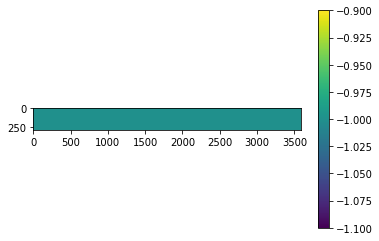

In [44]:
import matplotlib.pyplot as plt
import numpy as np
  
# Text file data converted to integer data type
File_data = np.loadtxt("viewshed_r3.txt", dtype=int)
# print(File_data)
plt.figure()
plt.imshow(File_data)
plt.colorbar()
plt.show()